In [79]:
import numpy as np
import matplotlib.pyplot as plt
import residue_constants
import pickle

TEMPLATE_FEATURES = {
    'template_aatype': np.float32,
    'template_all_atom_masks': np.float32,
    'template_all_atom_positions': np.float32,
    'template_domain_names': object,
    'template_sequence': object,
    'template_sum_probs': np.float32,
}

input_sequence = "TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE"    # GA98 sequence

In [84]:
def make_manual_template_features(pdb_path: str):
    """Read PDB file, return a list containing atoms coordinates and positions"""
    with open(pdb_path, 'r') as f:
        lines = f.readlines()
    
    # get pdb id and chain id
    file_name = pdb_path.split('/')[-1].split('.')[0]

    atoms = []
    for line in lines:
        if line.startswith('ATOM'):
            atom = line[12:16].strip()
            res_name = line[17:20].strip()
            res_id = int(line[22:26])
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            atoms.append([atom, res_name, res_id, x, y, z])
    
    # get the number of residues
    num_res = 0
    for atom in atoms:
        if atom[2] > num_res:
            num_res = atom[2]
    

    # create residue list
    residues = [[] for i in range(num_res)]
    for atom in atoms:
        residues[atom[2]-1].append(atom)

    sequence = "".join([residue_constants.restype_3to1[residues[i][0][1]] for i in range(num_res)])
    aa_type = residue_constants.sequence_to_onehot(sequence, residue_constants.HHBLITS_AA_TO_ID)
    

    
    
    all_positions = np.zeros([num_res, residue_constants.atom_type_num, 3])
    all_positions_mask = np.zeros([num_res, residue_constants.atom_type_num], dtype=np.int64)


    for res_index in range(num_res):
        pos = np.zeros([residue_constants.atom_type_num, 3], dtype=np.float32)
        mask = np.zeros([residue_constants.atom_type_num], dtype=np.float32)
        
        for atom in residues[res_index]:
            if atom[0] not in residue_constants.atom_types:
                continue
            atom_type_index = residue_constants.atom_types.index(atom[0])
            pos[atom_type_index, :] = atom[3:]
            mask[atom_type_index] = 1.0
        
        all_positions[res_index, :, :] = pos
        all_positions_mask[res_index, :] = mask


    return (
      {
          'template_all_atom_positions': np.array([all_positions], dtype=TEMPLATE_FEATURES['template_all_atom_positions']),
          'template_all_atom_masks': np.array([all_positions_mask], dtype=TEMPLATE_FEATURES['template_all_atom_masks']),
          'template_sequence': np.array([sequence.encode()], dtype=TEMPLATE_FEATURES['template_sequence']),
          'template_aatype': np.array([aa_type], dtype=TEMPLATE_FEATURES['template_aatype']),
          'template_domain_names': np.array([f'{file_name.lower()}'.encode()], dtype=TEMPLATE_FEATURES['template_domain_names']),
          'template_sum_probs': np.array([[100.0]], dtype=TEMPLATE_FEATURES['template_sum_probs']),
      })

In [85]:
test = make_manual_template_features("GA98_model_1.pdb")

In [86]:
feature = pickle.load(open('features.pkl', 'rb'))

In [87]:
print(feature["template_sum_probs"].shape)
print(test["template_sum_probs"].shape)

(20, 1)
(1, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


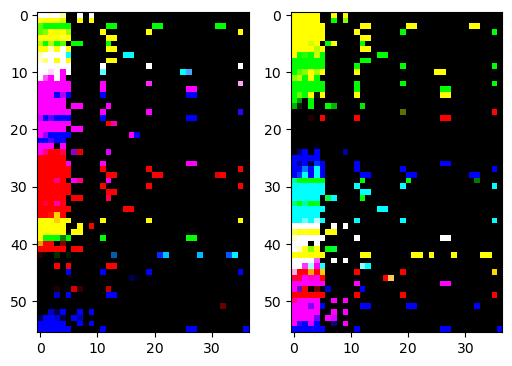

In [73]:
plt.figure(figsize=(6, 8))

plt.subplot(1, 2, 1)
plt.imshow(feature["template_domain_names"][1])

plt.subplot(1, 2, 2)
plt.imshow(test["template_domain_names"][0])
